## Plot filter evolution

For a given `wandb` run, download the filter parameters, and plot the filter evolution during training

In [1]:
import wandb
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sn_camels.scattering.create_filters import morlets
from sn_camels.scattering.scattering2d import scattering2d_learn
from sn_camels.models.models_factory import baseModelFactory

In [2]:
api = wandb.Api()
run = api.run("/chris-pedersen/compare_camels/runs/1d99npiz")
run_history=run.history();

In [3]:
data_string=os.environ['CAMELS_PATH']+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=os.environ['CAMELS_PATH']+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

In [ ]:
def parse_filter(run_history,epoch=-1):
    orientations=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('orientation_')]].to_numpy()[epoch]).float()
    xis=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[epoch]).float()
    sigmas=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('sigma_')]].to_numpy()[epoch]).float()
    slants=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('slant_')]].to_numpy()[epoch]).float()
    params_filters=[orientations,xis,sigmas,slants]
    wavelets=morlets((256,256),params_filters[0],params_filters[1],
                     params_filters[2],params_filters[3],device="cpu")
    
    return params_filters,wavelets

In [5]:
def plot_filter(run,epoch=-1):
    run_history=run.history();
    orientations=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('orientation_')]].to_numpy()[epoch]).float();
    xis=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[epoch]).float();
    sigmas=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('sigma_')]].to_numpy()[epoch]).float();
    slants=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('slant_')]].to_numpy()[epoch]).float();
    params_filters=[orientations,xis,sigmas,slants];
    wavelets=morlets((256,256),params_filters[0],params_filters[1],
                     params_filters[2],params_filters[3],device="cpu");
    
    scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    max_order=run.config["max_order"],
    initialization="Random",
    seed=123,
    learnable=run.config["learnable"],
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=run.config["skip"],
    split_filters=run.config["split_filters"],
    subsample=run.config["subsample"],
    filter_video=False,
    device="cpu",
    use_cuda=False
    );
    
    scatteringBase.params_filters=params_filters
    scatteringBase.updateFilters();
    
    out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.split_filters,
                scatteringBase.subsample,scatteringBase.scattering.out_type)
    
    filter_1=0
    filter_2=3
    second_order=5

    if scatteringBase.split_filters==False:
        order2_index=17+filter_1*16+filter_2
    else:
        filter_order_2=9
        order2_index=9+(filter_1)*8+second_order
        order2_index2=9+(filter_2)*8+second_order

    cdm_map_num=7 # between 0 and 10
    
    print("First order")
    
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("Original field")
    plt.imshow(np.log10(maps[cdm_map_num]));
    plt.subplot(1, 3, 2)
    plt.title("Wavelet filter")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("First order convolved field")
    plt.imshow(np.log10(out[cdm_map_num][filter_1+1]));
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("Original field")
    plt.imshow(np.log10(maps[cdm_map_num]));
    plt.subplot(1, 3, 2)
    plt.title("Wavelet filter")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("First order convolved field")
    plt.imshow(np.log10(out[cdm_map_num][filter_2+1]));
    
    print("Second order")
    
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("First order field")
    plt.imshow(np.log10(out[cdm_map_num][filter_1+1]));
    plt.subplot(1, 3, 2)
    plt.title("Second order filter 2 field")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("Second order field")
    plt.imshow(np.log10(out[cdm_map_num][order2_index]));
    
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("First order field")
    plt.imshow(np.log10(out[cdm_map_num][filter_2+1]));
    plt.subplot(1, 3, 2)
    plt.title("Second order filter 2 field")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("Second order field")
    plt.imshow(np.log10(out[cdm_map_num][order2_index2]));
    return params_filters,wavelets

First order
Second order


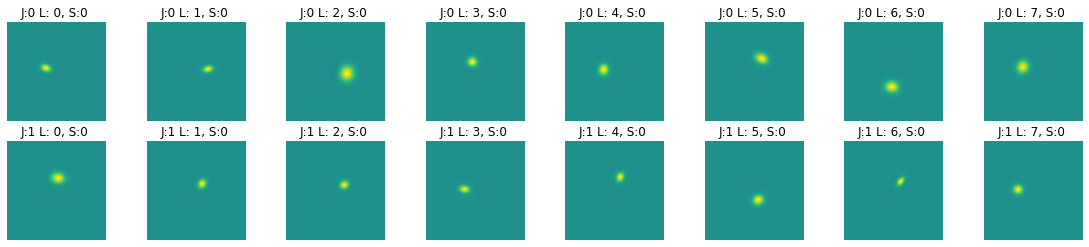

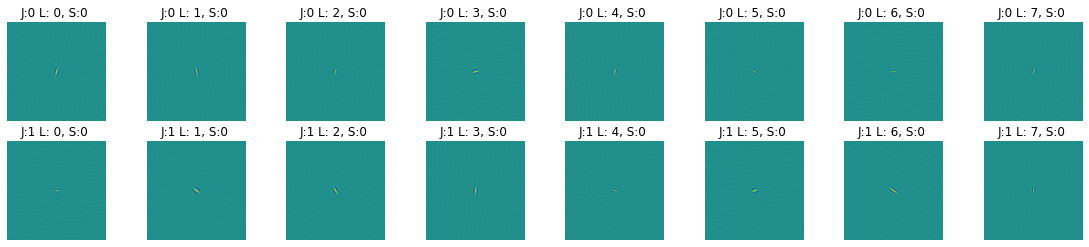

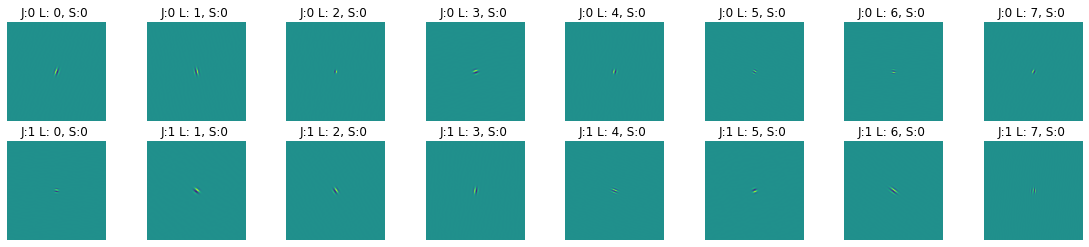

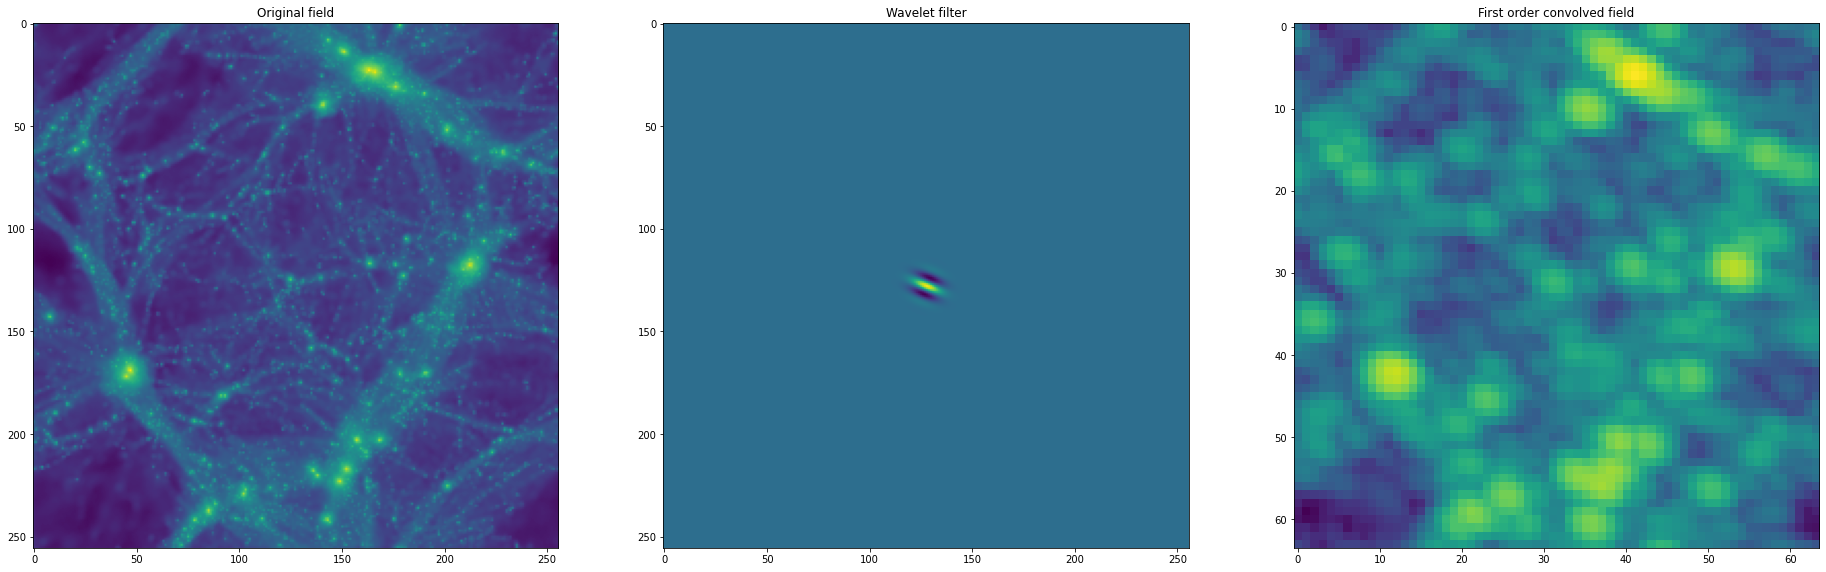

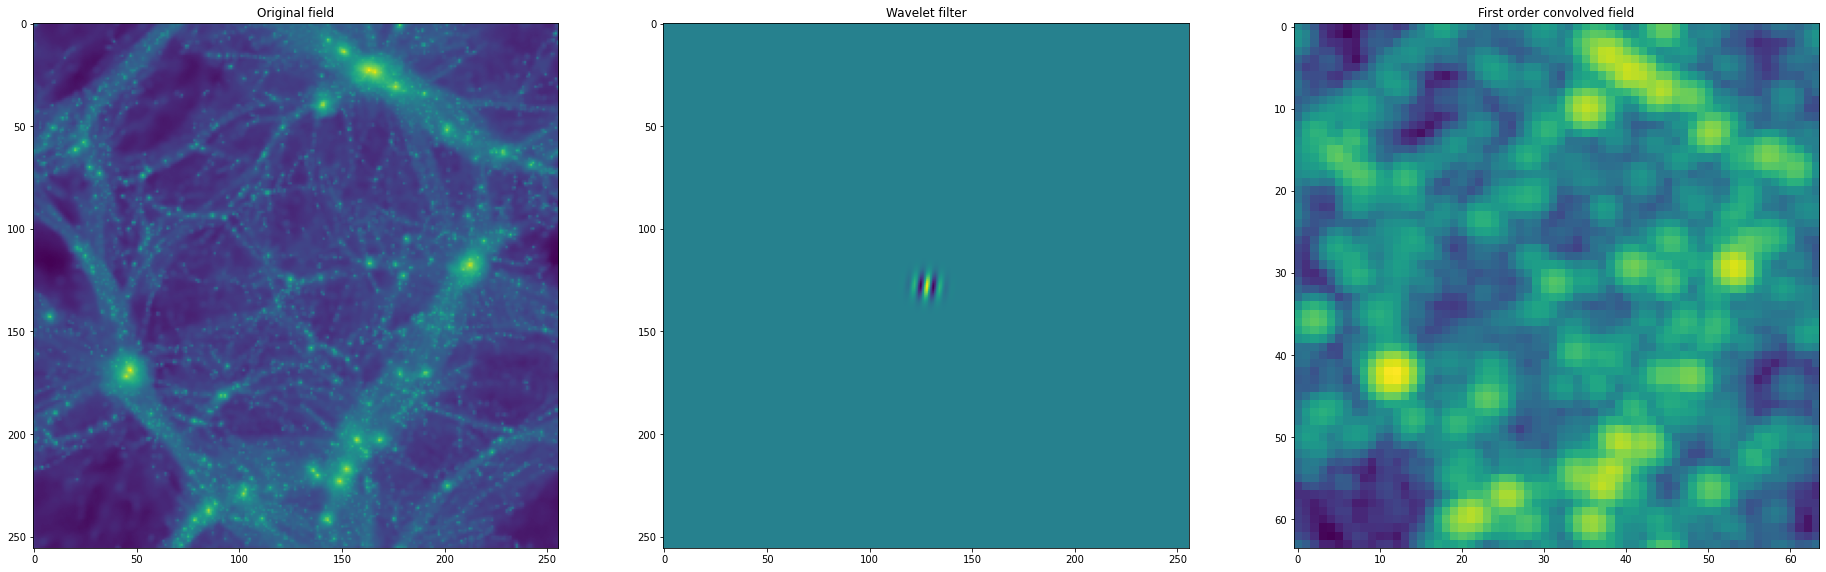

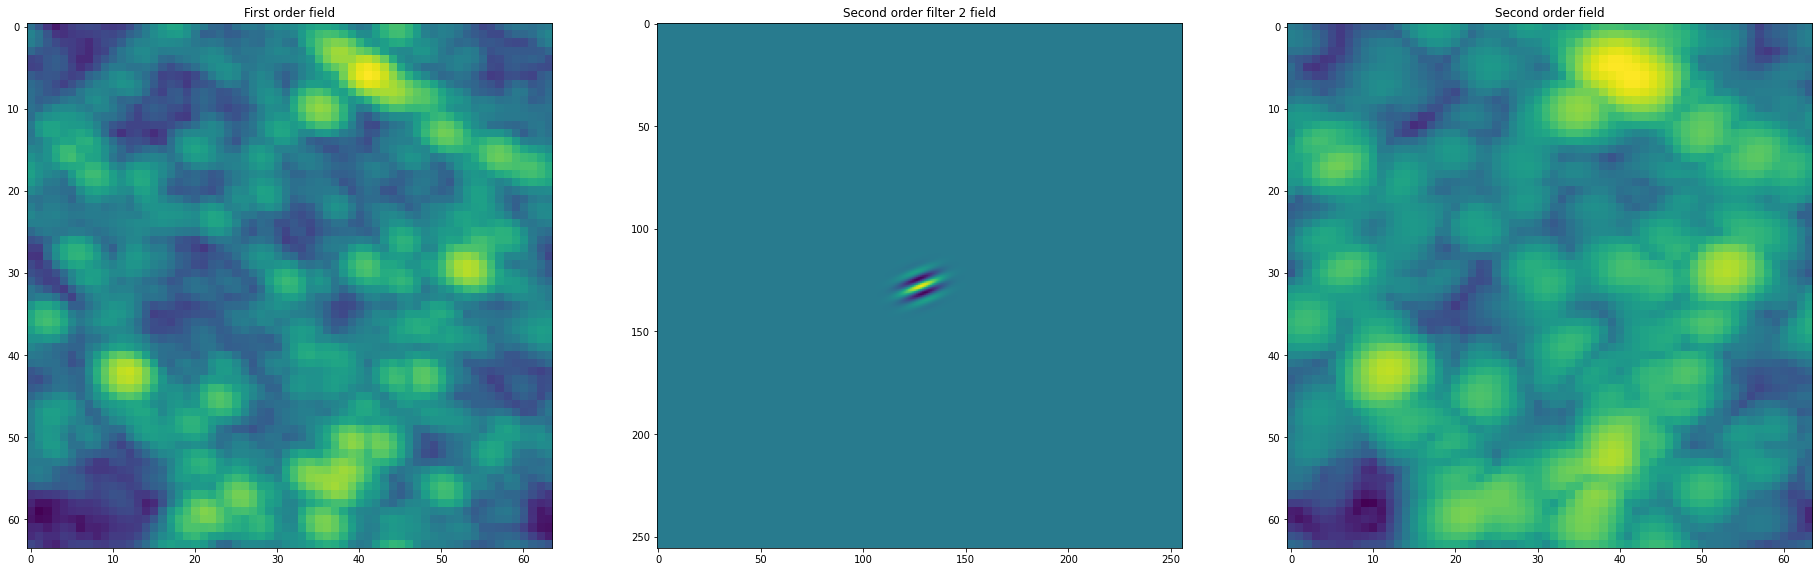

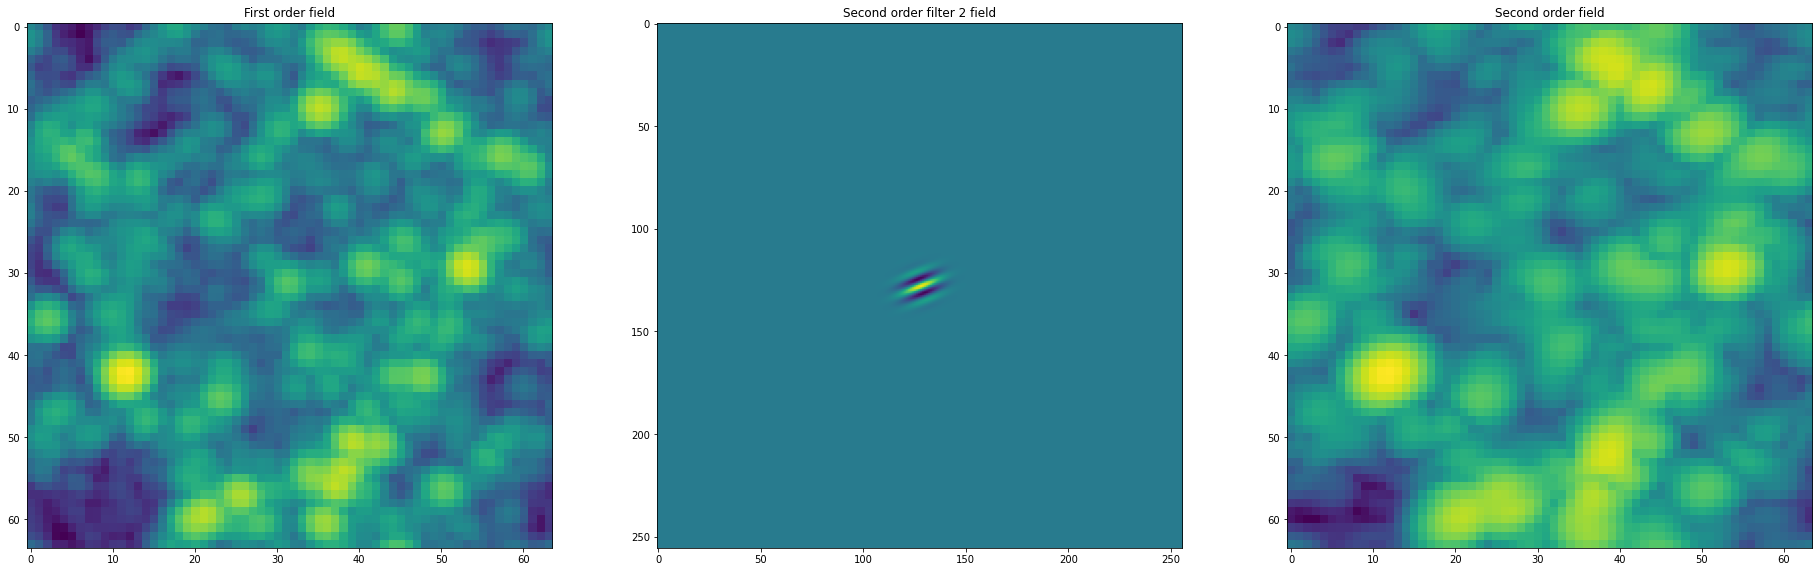

In [7]:
plot_filter(run,epoch=0);

First order
Second order


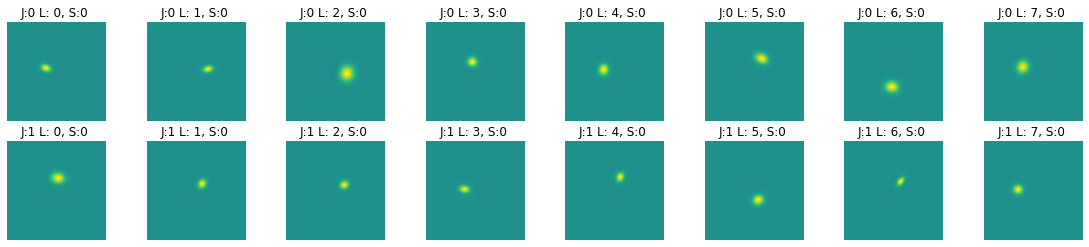

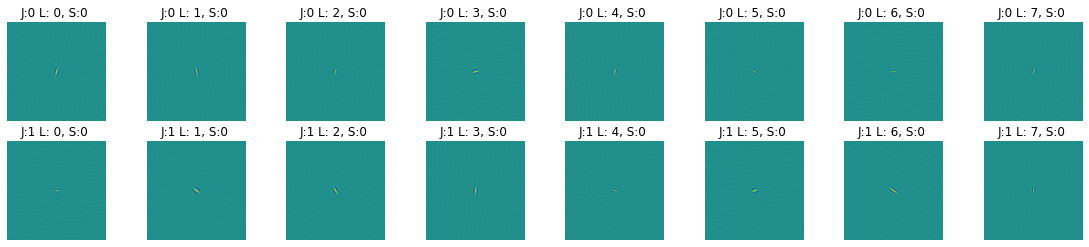

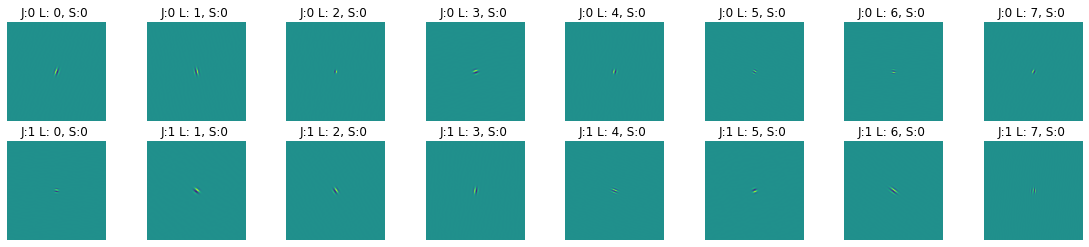

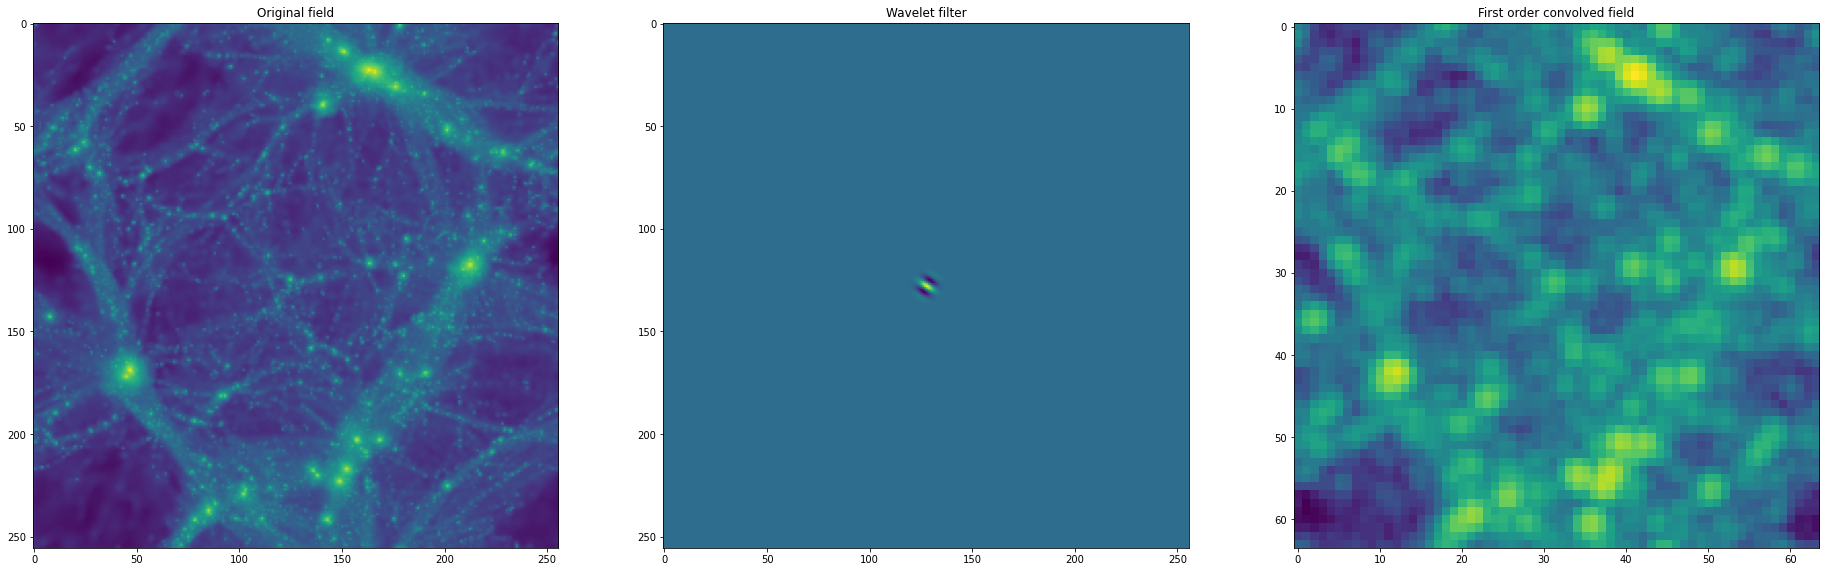

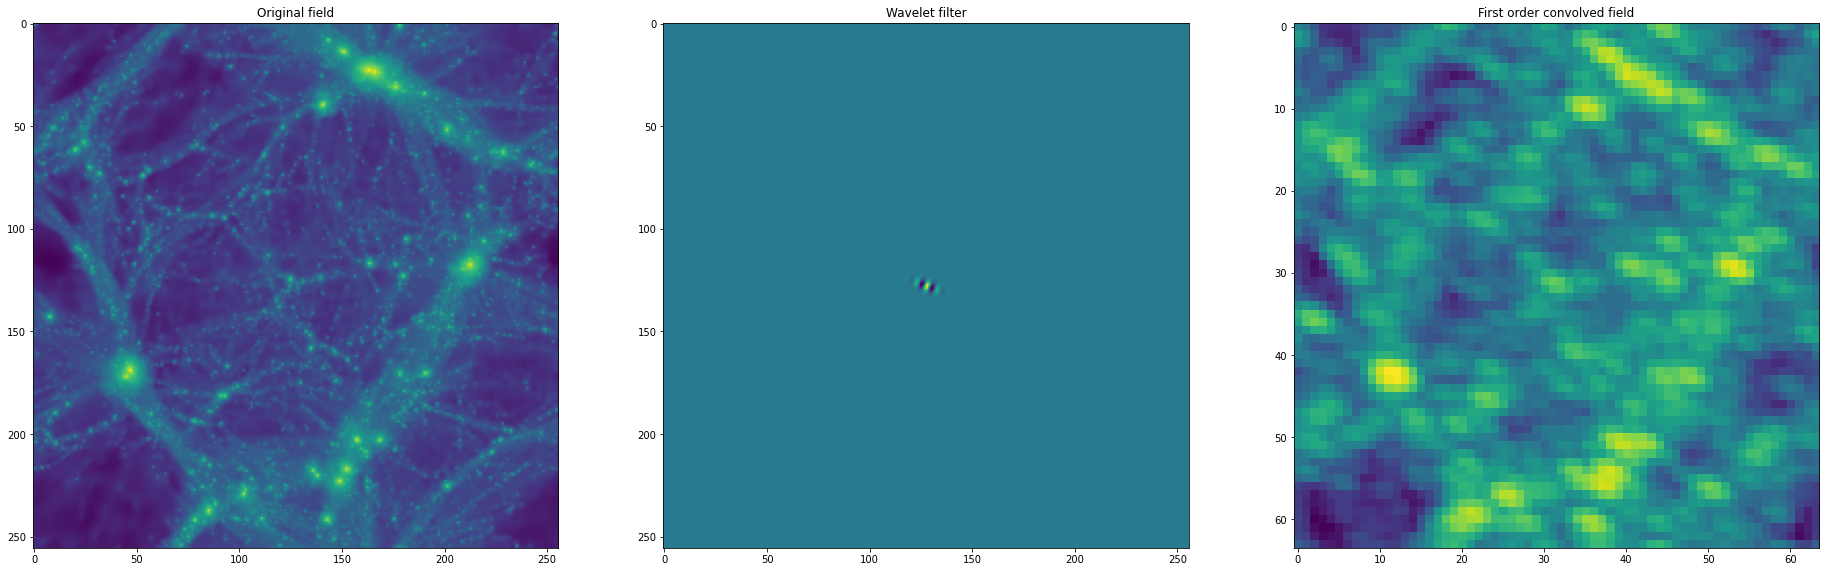

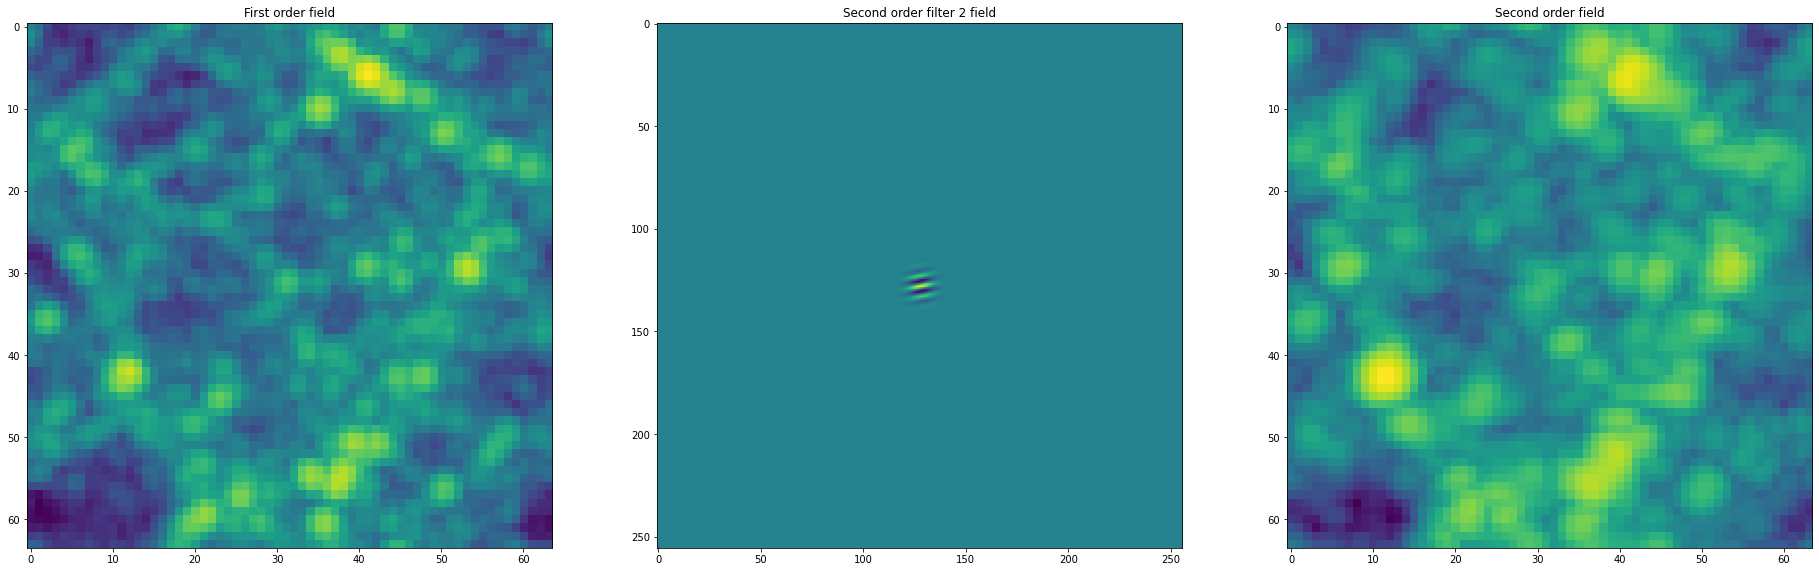

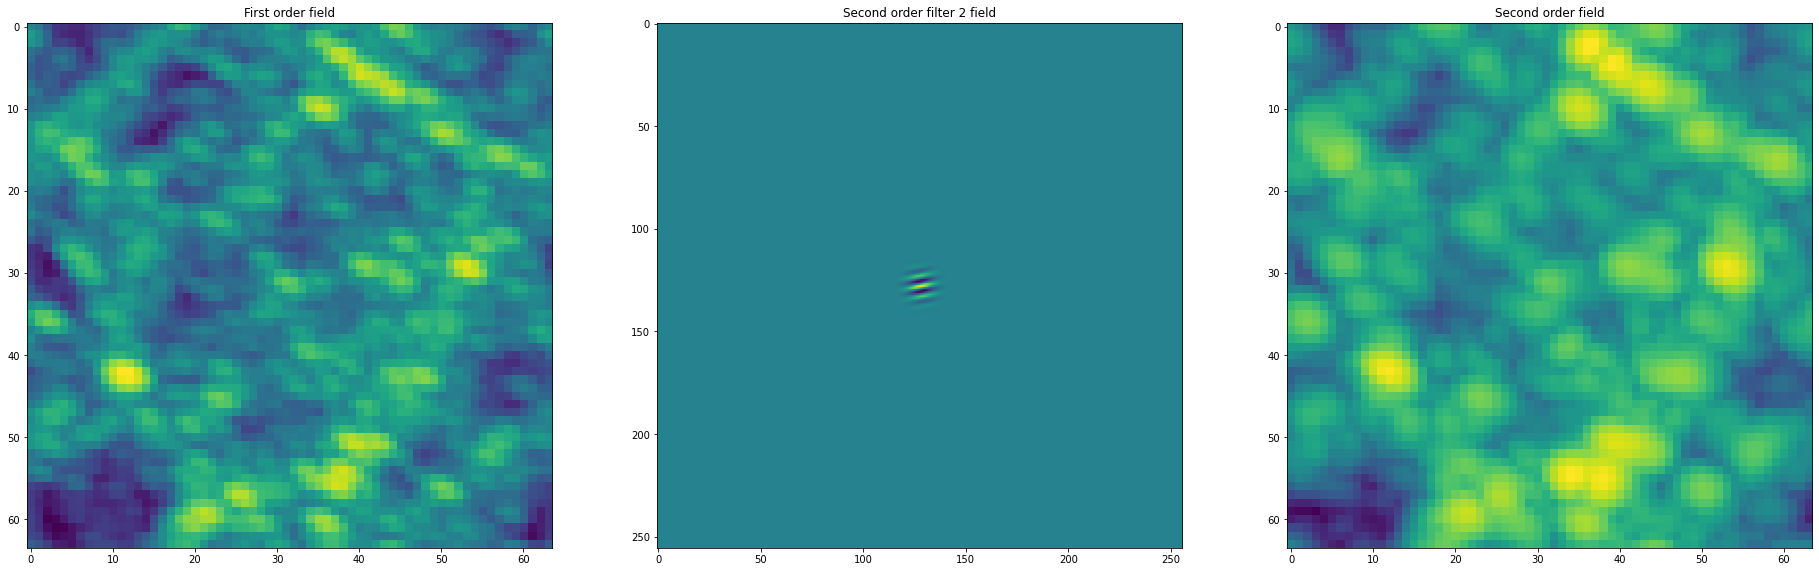

In [8]:
plot_filter(run);

In [ ]:
params_filters,wavelets=parse_filter_params(run_history)

In [ ]:
## So now need to take these wavelets, and convolve the test field with them now somehow
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    max_order=run.config["max_order"],
    initialization="Random",
    seed=123,
    learnable=run.config["learnable"],
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=run.config["skip"],
    split_filters=run.config["split_filters"],
    subsample=run.config["subsample"],
    filter_video=False,
    device="cpu",
    use_cuda=False
);

In [ ]:
scatteringBase.params_filters=params_filters
scatteringBase.updateFilters()

In [ ]:
type(scatteringBase.subsample)

In [ ]:
out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.split_filters,
                scatteringBase.subsample,scatteringBase.scattering.out_type)

In [ ]:
out.shape

In [ ]:
filter_1=0
filter_2=3
second_order=5

if scatteringBase.split_filters==False:
    order2_index=17+filter_1*16+filter_2
else:
    filter_order_2=9
    order2_index=9+(filter_1)*8+second_order
    order2_index2=9+(filter_2)*8+second_order

cdm_map_num=7 # between 0 and 10

In [ ]:
print(order2_index2)

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))

In [ ]:
### Block for split_filters=True
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.subplot(1, 3, 2)
plt.title("Second order filter 2 field")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index]))

In [ ]:
### Block for split_filters=True
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))
plt.subplot(1, 3, 2)
plt.title("Second order filter 2 field")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index2]))

In [ ]:

### Block for split_filters=False
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order 1 field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.subplot(1, 3, 2)
plt.title("First order 2 field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index]))

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(wavelets[filter_1].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.fft.fftshift(np.fft.ifft2(wavelets[filter_2].squeeze().cpu().detach().numpy())).real)
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(wavelets[filter_2].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.fft.fftshift(np.fft.ifft2(wavelets[filter_2].squeeze().cpu().detach().numpy())).real)

In [ ]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))

In [ ]:
waves=parse_filter_params(run_history)

In [ ]:
type(run.history())

In [ ]:
torch.tensor((10,2))

In [ ]:
run_history=run.history()

In [ ]:
run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[-1]

In [ ]:
len(history["xi_1"])

In [ ]:
len(history.columns[history.columns.str.startswith('xi_')])

In [ ]:
epoch=-1

In [ ]:
xis=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[epoch])
slants=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('slant_')]].to_numpy()[epoch])
sigmas=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('sigma_')]].to_numpy()[epoch])
orientations=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('orientation_')]].to_numpy()[epoch])

In [ ]:
xis

In [ ]:
params_filters=np.vstack((xis,slants,sigmas,orientations)).T

In [ ]:
params_filters.shape

In [ ]:
def parse_filter_params(run_history,epoch=-1):
    orientations=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('orientation_')]].to_numpy()[epoch]).float()
    xis=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[epoch]).float()
    sigmas=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('sigma_')]].to_numpy()[epoch]).float()
    slants=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('slant_')]].to_numpy()[epoch]).float()
    wavelets=morlets((256,256),orientations,xis,sigmas,slants,device="cpu")
    
    return wavelets
    
    
    

In [ ]:
waves=parse_filter_params(run_history)

In [ ]:
len(waves)

In [ ]:
## So the key thing we need here is some object to map from the 4 filter_params to a wavelet


In [ ]:
## Need a function to access the pandas dataframe, and rebuild the pytorch params_filters tensor

In [ ]:
test=torch.tensor([0.1,0.2])

In [ ]:
morlets((256,256),test,test,test,test,device="cpu")